# 1. Apply my method 

## Initialization

In [2]:
# Standard library
import re

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    auc
)

# Local modules (your CNA package)
from cna_inferer.annotation import annotate_genes_from_gtf
from cna_inferer.aggregation import sliding_window_aggregate
from cna_inferer.segmentation import call_cnas
from cna_inferer.main import process_and_call_cnas


## Read data & Gene annotation

In [3]:
# 1. Load Day 0 (or Day 8) data
adata0 = sc.read_h5ad("PBMC_simulated_cnas_041025.h5ad")
adata0.var_names_make_unique()

adata0.var["chromosome"] = adata0.var["chromosome"].astype(str)
adata0 = adata0[:, adata0.var.sort_values(["chromosome", "start"]).index]

# 2. Gene annotation using local GTF file
# adata0 = annotate_genes_from_gtf(adata0, "Homo_sapiens.GRCh38.104.gtf")
adata0.var[["chromosome","start"]].head()


,chromosome,start
original_index,,
AL627309.3,1,89551.0
LINC00115,1,586945.0
AL669831.5,1,778739.0
FAM87B,1,817363.0
FAM41C,1,868052.0


In [4]:
# total = data.shape[1]
# missing = data.var['chromosome'].isna().sum()
# print(f"✅ Annotation successful: {total - missing} / {total} ({(total - missing)/total:.1%})")
# print(f"❗ Unannotated: {missing} genes")

## QC filter & Normalization

C:\Users\12039\AppData\Local\Temp\ipykernel_37776\936217202.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata0.var['mt'] = adata0.var_names.str.upper().str.startswith('MT-')
c:\Users\12039\anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
... storing 'chromosome' as categorical


Number of cells after filtering: 10309
Number of genes after filtering: 19776


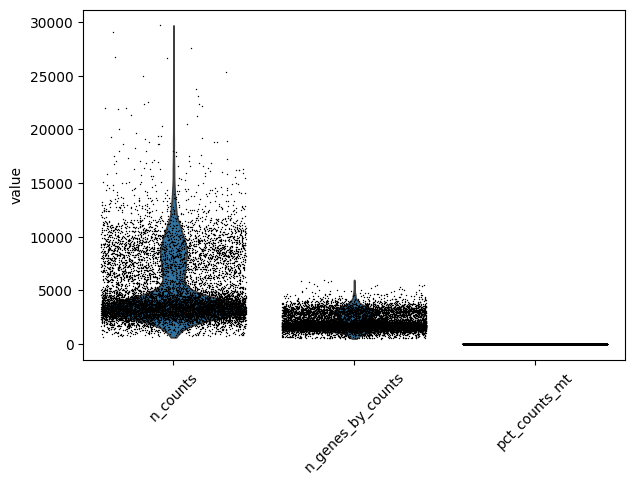

In [5]:
adata0.var['mt'] = adata0.var_names.str.upper().str.startswith('MT-')

sc.pp.calculate_qc_metrics(
    adata0,
    qc_vars=['mt'],
    percent_top=None, # Do not calculate the top n gene groups
    log1p=False, # Do not do log1p here
    inplace=True
)

# Filter
sc.pp.filter_cells(adata0, min_counts=500)
sc.pp.filter_cells(adata0, max_counts=50000)
adata0 = adata0[adata0.obs['pct_counts_mt'] < 5, :]
sc.pp.filter_genes(adata0, min_cells=3)

# Normalize + log1p
adata0.raw = adata0.copy()
sc.pp.normalize_total(adata0, target_sum=1e4)
sc.pp.log1p(adata0)

# Visual confirmation
print("Number of cells after filtering:", adata0.n_obs)
print("Number of genes after filtering:", adata0.n_vars)
sc.pl.violin(
    adata0,
    ['n_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    jitter=0.4, rotation=45
)

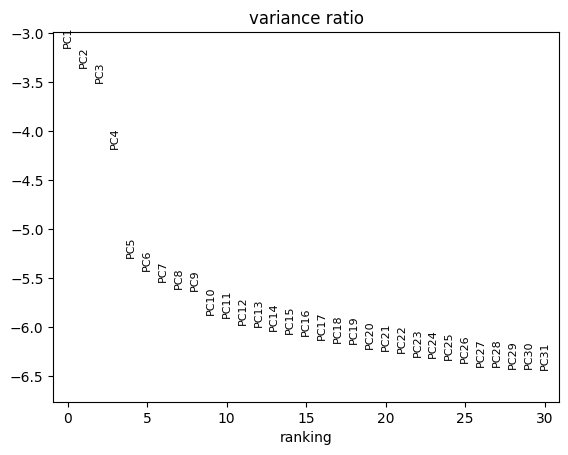

In [6]:
sc.pp.highly_variable_genes(adata0, n_top_genes=2000)
sc.pp.scale(adata0)
sc.tl.pca(adata0)
sc.pl.pca_variance_ratio(adata0, log=True)


## Sort Genes & Sliding-Window Aggregation

In [7]:

# 5. Sort .var by chromosome and position (critical step)
chrom_order = [str(i) for i in range(1, 23)] + ["X", "Y"]
adata0.var["chromosome"] = pd.Categorical(adata0.var["chromosome"],
                                          categories=chrom_order, ordered=True)
adata0.var = adata0.var.sort_values(["chromosome", "start"])
adata0._inplace_subset_var(adata0.var.index)

# 6. Sliding-window aggregation + CNA calling
adata0 = sliding_window_aggregate(adata0, window_size=100)


In [8]:
# Simply print the first few lines to confirm whether they are sorted by chr and start
print(adata0.var[["chromosome", "start"]].head(10))
print("X_binned shape:", adata0.obsm["X_binned"].shape) # It should be (cells, bins)

# You can roughly calculate the number of bins ≈ n_genes / window_size
print("Original number of genes:", adata0.n_vars)
print("Number of bins after sliding window:", adata0.obsm["X_binned"].shape[1])

               chromosome     start
original_index                     
AL627309.3              1   89551.0
LINC00115               1  586945.0
AL669831.5              1  778739.0
FAM87B                  1  817363.0
FAM41C                  1  868052.0
SAMD11                  1  923923.0
NOC2L                   1  944203.0
KLHL17                  1  960584.0
PLEKHN1                 1  966482.0
PERM1                   1  975198.0
X_binned shape: (10309, 198)
Original number of genes: 19776
Number of bins after sliding window: 198


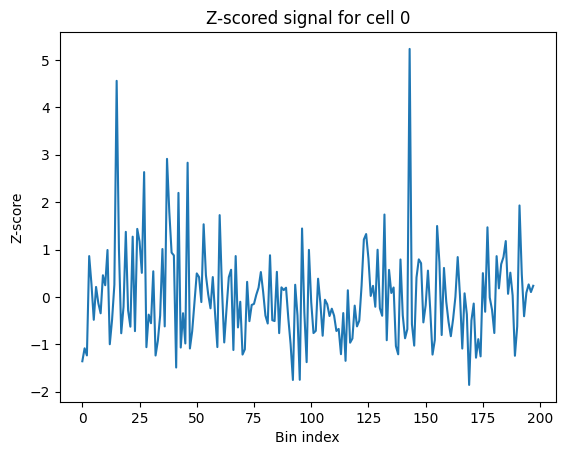

In [9]:


Xb = adata0.obsm["X_binned"]
Xz = (Xb - Xb.mean(axis=1, keepdims=True)) / (Xb.std(axis=1, keepdims=True) + 1e-6)

plt.plot(Xz[0])
plt.title("Z-scored signal for cell 0")
plt.xlabel("Bin index")
plt.ylabel("Z-score")
plt.show()


In [10]:
adata_sub = adata0.copy()

w_size = 100
# 2. Sliding window aggregation (default window size 100)
# adata_sub = sliding_window_aggregate(adata_sub, window_size=w_size)

# 3. Fast CNA calling (model='l2', faster; only 1 core is used to avoid parallel overhead)
adata_sub = call_cnas(
    adata_sub,
    window_size = w_size , # One bin ~100 genes, covering ~10–15 Mb, just matching your 9–10 Mb interval. Default is 100
    z_thresh = 2 , # Lower than the default 1.5 to reduce false negatives
    min_bins = 5 , # Keep it the same and ensure that it spans at least 3 bins. Default is 3
    n_bkps = 8 , # Three events ≈ 6 breakpoints (the front and back boundaries of the 3 intervals) Default is 8
    model = "l2", # Keep the nonlinear kernel to capture fluctuations more flexibly
    n_jobs = 1
)
# 4. Z-score heat map (visualization of aggregate expression)
Xbinned = adata_sub.obsm["X_binned"]
z = (Xbinned - Xbinned.mean(0)) / Xbinned.std(0)

# Flatten the Z-score of all bins
zs = z.ravel()

event_counts = [len(segments) for segments in adata_sub.obs["cna_calls"]]
adata_sub.obs["n_cna_events"] = event_counts

# Total number of events
print("📊 Total number of events:", sum(event_counts))

✅ Processed 0 cells...
✅ Processed 500 cells...
✅ Processed 1000 cells...
✅ Processed 1500 cells...
✅ Processed 2000 cells...
✅ Processed 2500 cells...
✅ Processed 3000 cells...
✅ Processed 3500 cells...
✅ Processed 4000 cells...
✅ Processed 4500 cells...
✅ Processed 5000 cells...
✅ Processed 5500 cells...
✅ Processed 6000 cells...
✅ Processed 6500 cells...
✅ Processed 7000 cells...
✅ Processed 7500 cells...
✅ Processed 8000 cells...
✅ Processed 8500 cells...
✅ Processed 9000 cells...
✅ Processed 9500 cells...
✅ Processed 10000 cells...
📊 Total number of events: 145


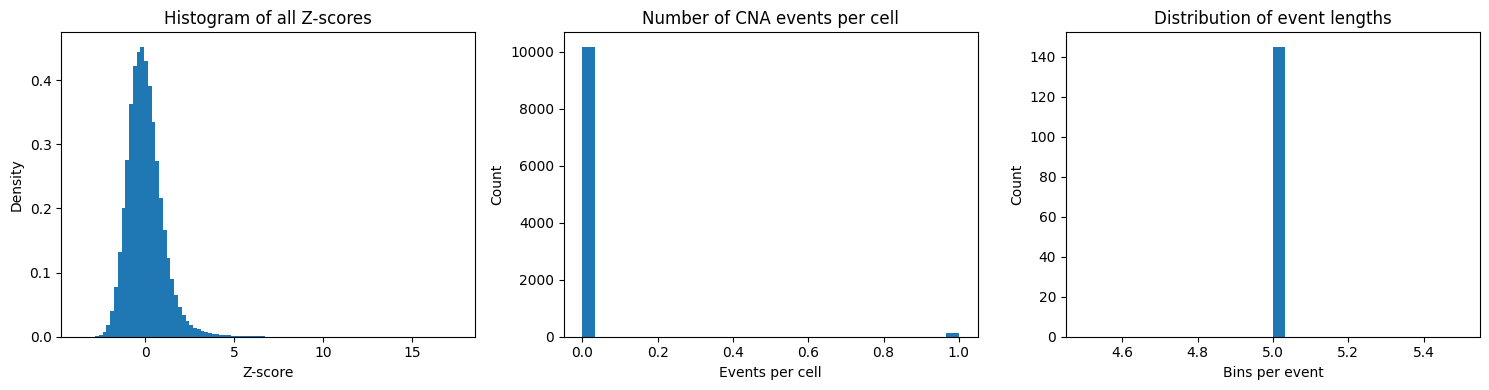

In [11]:

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- Figure 1: Z-score distribution ---
axes[0].hist(zs, bins=100, density=True)
axes[0].set_title("Histogram of all Z-scores")
axes[0].set_xlabel("Z-score")
axes[0].set_ylabel("Density")

# --- Figure 2: Number of events per cell ---
calls = adata_sub.obs["cna_calls"].apply(len)
axes[1].hist(calls, bins=30)
axes[1].set_title("Number of CNA events per cell")
axes[1].set_xlabel("Events per cell")
axes[1].set_ylabel("Count")

# --- Figure 3: Event length distribution ---
df = adata_sub.uns["cna_events"]
if not df.empty:
    df["length"] = df["end_bin"] - df["start_bin"] + 1
    axes[2].hist(df["length"], bins=30)
    axes[2].set_title("Distribution of event lengths")
    axes[2].set_xlabel("Bins per event")
    axes[2].set_ylabel("Count")
else:
    axes[2].text(0.5, 0.5, "No events detected", ha="center", va="center")
    axes[2].set_title("Distribution of event lengths")
    axes[2].set_xlabel("Bins per event")
    axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


### All above is the same to the one line code below:

In [12]:
# adata = process_and_call_cnas("GSM3814888_day8_rep1_filtered_gene_bc_matrices_h5.h5")

## Result check

In [13]:
print("Number of events:", len(adata_sub.uns["cna_events"]))  
print(adata_sub.uns["bin_info"].head())                     
print(adata_sub.uns["cna_events"].head())

Number of events: 145
  chromosome  start_gene
0          1     89551.0
1          1   6393555.0
2          1  15571699.0
3          1  23964347.0
4          1  29192657.0
                 cell  start_bin  end_bin  type chromosome   start_gene  \
0  AAATGGAAGAGGGTAA-1        160      164  gain         19    1397026.0   
1  AACAGGGCACGACCTG-1         45       49  gain          4   47485275.0   
2  AACCAACAGATTAGCA-1         80       84  gain          8   94719703.0   
3  AACCCAATCAAGTCTG-1        100      104  gain         11   47381509.0   
4  AACGTCATCAGACATC-1         10       14  gain          1  112709994.0   

   length  
0       5  
1       5  
2       5  
3       5  
4       5  


## Plot

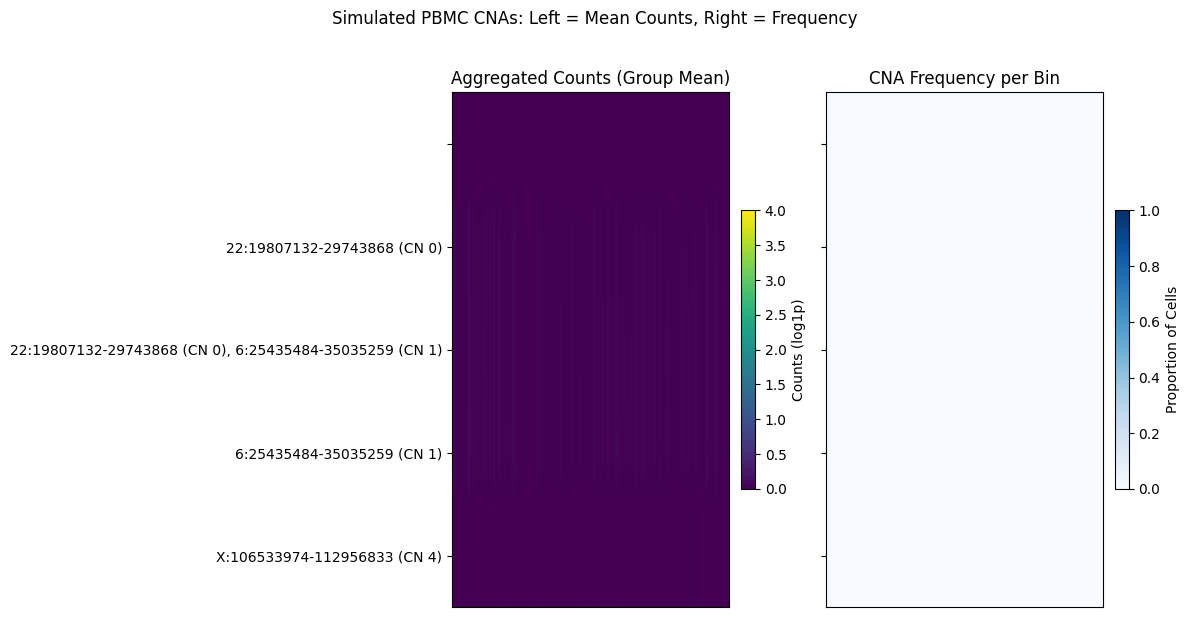

In [14]:
adata_sim = adata_sub.copy()

# 2. Extract binned counts and CNA calls
Xb = adata_sim.obsm["X_binned"]             # (n_cells, n_bins)
calls = adata_sim.obs["cna_calls"]          # list of CNA events per cell
groups = adata_sim.obs["simulated_cnvs"].astype(str)
unique_groups = pd.Categorical(groups).categories

# 3. Construct group-level matrices
n_bins = Xb.shape[1]
counts_mat = np.zeros((len(unique_groups), n_bins))
freq_mat = np.zeros_like(counts_mat)

for i, grp in enumerate(unique_groups):
    mask = (groups == grp).values
    # Aggregate mean counts within group
    counts_mat[i] = Xb[mask].mean(axis=0)
    # Compute fraction of cells with CNA per bin
    total = mask.sum()
    hits = np.zeros(n_bins, dtype=int)
    for cell_calls in calls[mask]:
        for ev in cell_calls:
            hits[ev["start"] : ev["end"] + 1] += 1
    freq_mat[i] = hits / total

# 4. Plot: dual panels for group × bin data
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True,
                               gridspec_kw={"width_ratios": [1, 1]})

# Left: Group-averaged binned counts
im0 = ax0.imshow(counts_mat, aspect="auto", cmap="viridis", vmin=0, vmax=4)
ax0.set_title("Aggregated Counts (Group Mean)")
ax0.set_xticks([])
ax0.set_yticks(np.arange(len(unique_groups)))
ax0.set_yticklabels(unique_groups)
c0 = fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
c0.set_label("Counts (log1p)")

# Right: CNA frequency per bin (white = 0 → dark blue = 1)
im1 = ax1.imshow(freq_mat, aspect="auto", cmap="Blues", vmin=0, vmax=1)
ax1.set_title("CNA Frequency per Bin")
ax1.set_xticks([])
# y-labels are shared with ax0
c1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
c1.set_label("Proportion of Cells")

plt.suptitle("Simulated PBMC CNAs: Left = Mean Counts, Right = Frequency", y=1.02)
plt.tight_layout()
plt.show()


# 2. Performance Assessment

In [15]:
# Get bin info and midpoints of each bin
bin_info = adata_sim.uns["bin_info"]
mids     = bin_info["start_gene"].values  

# Initialize ground truth and prediction matrices
n_cells, n_bins = adata_sim.n_obs, len(bin_info)
y_true = np.zeros((n_cells, n_bins), dtype=int)

# Loop over each cell's simulated CNVs and mark the affected bins
for i, label in enumerate(adata_sim.obs["simulated_cnvs"]):
    if not isinstance(label, str) or ":" not in label:
        continue
    for seg in re.split(r"[;,]\s*", label):
        # Parse segment string like "chr1:100000-300000 (CN 3)"
        match = re.match(r"(\w+):(\d+)-(\d+)\s*\(CN\s+(\d+)\)", seg)
        if not match:
            print(f"⚠️ Skipped malformed segment: {seg}")
            continue
        chrom = match.group(1)
        s     = int(match.group(2))  # start position
        e     = int(match.group(3))  # end position
        cn    = int(match.group(4))  # copy number (can be used to distinguish gain/loss)

        chrom = str(chrom)  # Ensure chromosome is a string
        mids  = bin_info["start_gene"].values
        # Mark bins within this region for this cell
        mask = (bin_info["chromosome"] == chrom) & (mids >= s) & (mids <= e)
        y_true[i, mask.values] = 1

# Fill in predicted CNA matrix from inferred events
y_pred = np.zeros_like(y_true)
for i, calls in enumerate(adata_sim.obs["cna_calls"]):
    for ev in calls:
        # Mark predicted bins as 1
        y_pred[i, ev["start"]:ev["end"]+1] = 1


## Result

In [16]:
# 1. Flatten the true and predicted labels into 1D arrays
y_true_flat = y_true.ravel()
y_pred_flat = y_pred.ravel()

# 2. Compute continuous scores using z-scores across bins
z_matrix = (Xb - Xb.mean(axis=1, keepdims=True)) / Xb.std(axis=1, keepdims=True)
y_score = z_matrix.ravel()

# 3. Precision-Recall curve & AUPR score
precision, recall, _ = precision_recall_curve(y_true_flat, y_score)
aupr = average_precision_score(y_true_flat, y_score)

# 5. Generate classification report table using binary predictions
report_dict = classification_report(
    y_true_flat, y_pred_flat,
    target_names=["no CNA", "CNA"],
    digits=3,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).T
report_df = report_df[["precision", "recall", "f1-score", "support"]]

# Display results
print("Classification Report:")
print(report_df)

Classification Report:
              precision    recall  f1-score       support
no CNA         0.997767  0.999646  0.998705  2.036621e+06
CNA            0.005517  0.000877  0.001513  4.561000e+03
accuracy       0.997414  0.997414  0.997414  9.974142e-01
macro avg      0.501642  0.500261  0.500109  2.041182e+06
weighted avg   0.995550  0.997414  0.996477  2.041182e+06


In [17]:
# adata_sim.obs["simulated_cnvs"]
categories = list(adata_sim.obs["simulated_cnvs"].cat.categories)
for i, cat in enumerate(categories):
    print(f"{i}. {cat}")

0. 
1. 6:25435484-35035259 (CN 1)
2. 22:19807132-29743868 (CN 0)
3. 22:19807132-29743868 (CN 0), 6:25435484-35035259 (CN 1)
4. X:106533974-112956833 (CN 4)


In [18]:
print("Number of events:", len(adata_sub.uns["cna_events"]))  
df = adata_sub.uns["cna_events"]  

df["end_gene"] = df["end_bin"].map(adata_sub.uns["bin_info"]["start_gene"])
print(df[["cell", "chromosome", "start_gene","end_gene", "start_bin", "end_bin"]].head())     
# print(adata_sub.uns["cna_events"].head())

Number of events: 145
                 cell chromosome   start_gene     end_gene  start_bin  end_bin
0  AAATGGAAGAGGGTAA-1         19    1397026.0   14333630.0        160      164
1  AACAGGGCACGACCTG-1          4   47485275.0  165277807.0         45       49
2  AACCAACAGATTAGCA-1          8   94719703.0   35649295.0         80       84
3  AACCCAATCAAGTCTG-1         11   47381509.0   75434640.0        100      104
4  AACGTCATCAGACATC-1          1  112709994.0  161524540.0         10       14


In [19]:
# See if there are events on chromosomes 6, 22, X in the prediction
hits = df[df["chromosome"].isin(["6", "22", "X"])]
print("Number of events:", len(hits))  
print(hits[["cell", "chromosome", "start_gene","end_gene", "start_bin", "end_bin", "type"]].head(60))


Number of events: 14
                   cell chromosome   start_gene     end_gene  start_bin  \
7    ACCAAACTCGTGTGAT-1          6   27815022.0  100508194.0         60   
19   AGCGTCGCATGACACT-1         22   42835412.0   75156388.0        185   
26   ATTCCATCAATTGCCA-1          X  118346073.0          NaN        190   
33   CACTTCGTCGTAGAGG-1          6  127266726.0   33094797.0         65   
36   CAGTTCCGTAGTAAGT-1          6   27815022.0  100508194.0         60   
52   CTACCCACAAGCTGTT-1         22   42835412.0   75156388.0        185   
58   CTCCAACCAATTTCCT-1          X  118346073.0          NaN        190   
76   GATCACAAGACGACTG-1          X  118346073.0          NaN        190   
108  TAACCAGAGATCCCGC-1          6   27815022.0  100508194.0         60   
110  TAATTCCGTCGTGGTC-1          6  127266726.0   33094797.0         65   
137  TTCCGTGTCAAGCGTT-1          6   27815022.0  100508194.0         60   
141  TTGCTGCTCTACACTT-1          6   27815022.0  100508194.0         60   
142 

In [20]:
# Assume bin_info already contains 'chromosome' and genomic midpoint info
mids = (bin_info["start_gene"] + bin_info["start_gene"].shift(-1).fillna(bin_info["start_gene"])) / 2

# Define the ground-truth CNV segments (chromosome, start, end)
truth_segs = [
    ("6", 25435484, 35035259),
    ("22", 19807132, 29743868),
    ("X", 106533974, 112956833)
]

# Collect indices of bins overlapping the true CNV regions
eval_bins = []
for chrom, s, e in truth_segs:
    mask = (
        (bin_info["chromosome"] == chrom) &
        (mids >= s) &
        (mids <= e)
    )
    eval_bins += list(np.where(mask.values)[0])

# Extract predictions and ground truth for just the selected CNV bins
y_true_sub  = y_true_flat.reshape(n_cells, n_bins)[:, eval_bins].ravel()
y_pred_sub  = y_pred_flat.reshape(n_cells, n_bins)[:, eval_bins].ravel()
y_score_sub = y_score.reshape(n_cells, n_bins)[:, eval_bins].ravel()

# Compute precision-recall and AUPR on the subset
prec, rec, _ = precision_recall_curve(y_true_sub, y_score_sub)
aupr_sub = auc(rec, prec)

# Display result
print("AUPR on CNV regions:", aupr_sub)


AUPR on CNV regions: 0.09575535303513462


## Plot

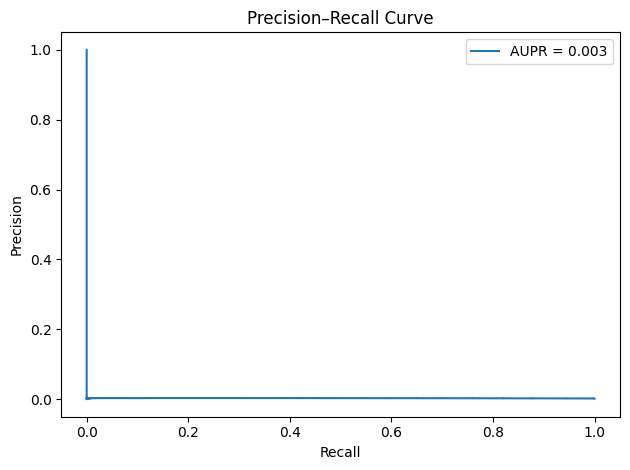

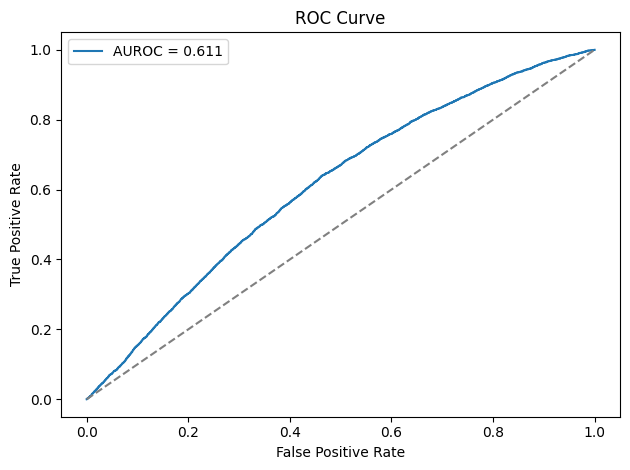

In [21]:
# === Precision–Recall Curve ===
plt.figure()
plt.plot(recall, precision, label=f"AUPR = {aupr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_true_flat, y_score)
auroc = roc_auc_score(y_true_flat, y_score)

plt.figure()
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()
